In [ ]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from dotenv import load_dotenv
import os

load_dotenv()

root = root_path = os.getenv('ROOT')

eng = matlab.engine.start_matlab()

print("matlab egine started")

matlab egine started


In [ ]:
eng.addpath(root, nargout=0)



In [186]:
fs = 48e3
Tsymb = 1e-3
fc = 10e3
M = 8.0
Var = 1.0

sps = fs*Tsymb  
Nsymb = 2048

output_len = Nsymb*sps 

In [187]:
data = eng.mqam_gui(output_len, fs, Tsymb, fc, M)
data = np.array(data).flatten()

T = len(data)/fs

t = np.linspace(0,T,len(data))

(0.0, 0.0425)

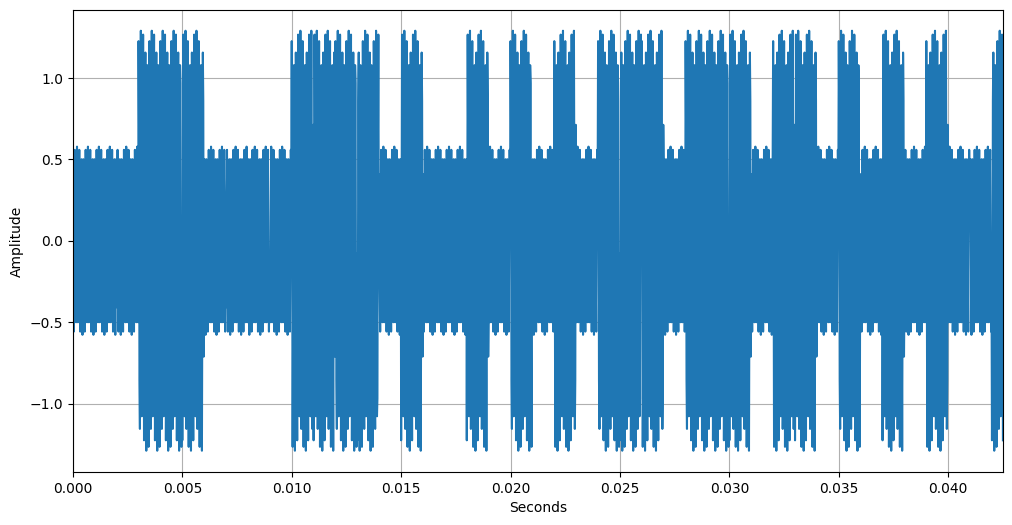

In [188]:
plt.figure(figsize=(12,6))
plt.plot(t,data)
plt.grid(True)
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.xlim([0,0.0425])

In [189]:
freqs, ft = eng.plotspec_gui(data, 1/fs, nargout = 2)
freqs = np.array(freqs).flatten()
ft = np.array(ft).flatten()

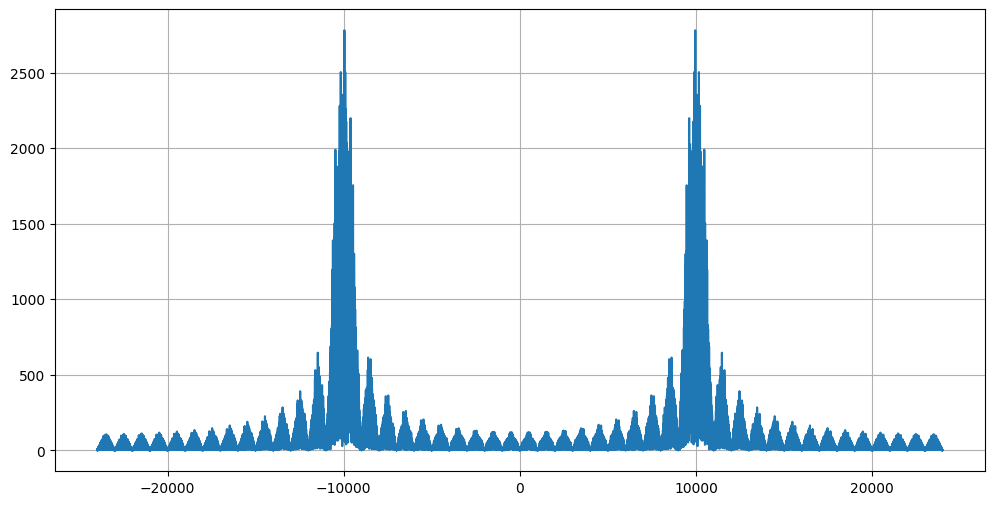

In [190]:
plt.figure(figsize=(12,6))
plt.plot(freqs, np.abs(ft))
plt.grid(True)

In [222]:
# OFDM Parameters
M_ofdm = 4           # Modulation order for 16-QAM
nfft = 128           # FFT length (number of subcarriers)
cplen = 16           # Cyclic prefix length
nSym = 100           # Number of OFDM symbols
nStreams = 1         # Number of transmit streams

# Generate random data symbols (0 to M-1)
dataIn = eng.randi(matlab.double([0, M_ofdm-1]), float(nfft), float(nSym), float(nStreams))

# QAM modulation
qamSig = eng.qammod(dataIn, float(M_ofdm), 'UnitAveragePower', True)

# OFDM modulation (adds cyclic prefix)
ofdm_signal = eng.ofdmmod(qamSig, float(nfft), float(cplen))

# Convert to numpy array
ofdm_signal = np.array(ofdm_signal).flatten()

print(f"OFDM signal length: {len(ofdm_signal)} samples")
print(f"Expected length: {nSym * (nfft + cplen)} samples")
print(f"Number of OFDM symbols: {nSym}")
print(f"Samples per OFDM symbol (with CP): {nfft + cplen}")

OFDM signal length: 14400 samples
Expected length: 14400 samples
Number of OFDM symbols: 100
Samples per OFDM symbol (with CP): 144


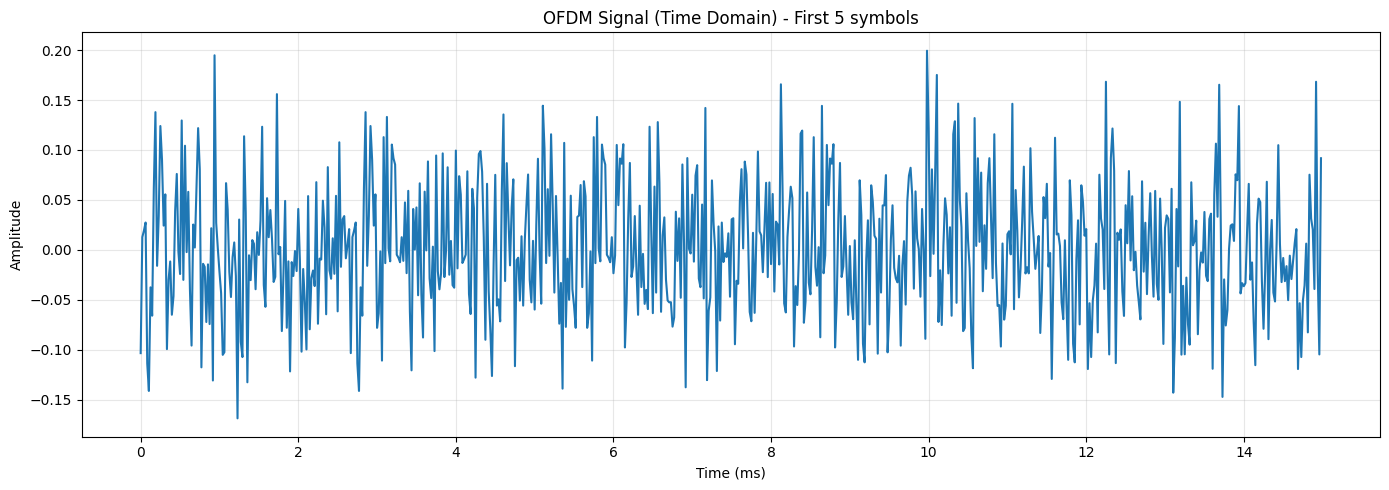

In [223]:
# Plot time domain OFDM signal
plt.figure(figsize=(14,5))

# Show first few symbols
samples_to_plot = 5 * (nfft + cplen)  # First 5 OFDM symbols
time_vec = np.arange(samples_to_plot) / fs

plt.plot(time_vec * 1e3, ofdm_signal[:samples_to_plot])  # Convert to milliseconds
plt.grid(True, alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title(f'OFDM Signal (Time Domain) - First 5 symbols')
plt.tight_layout()

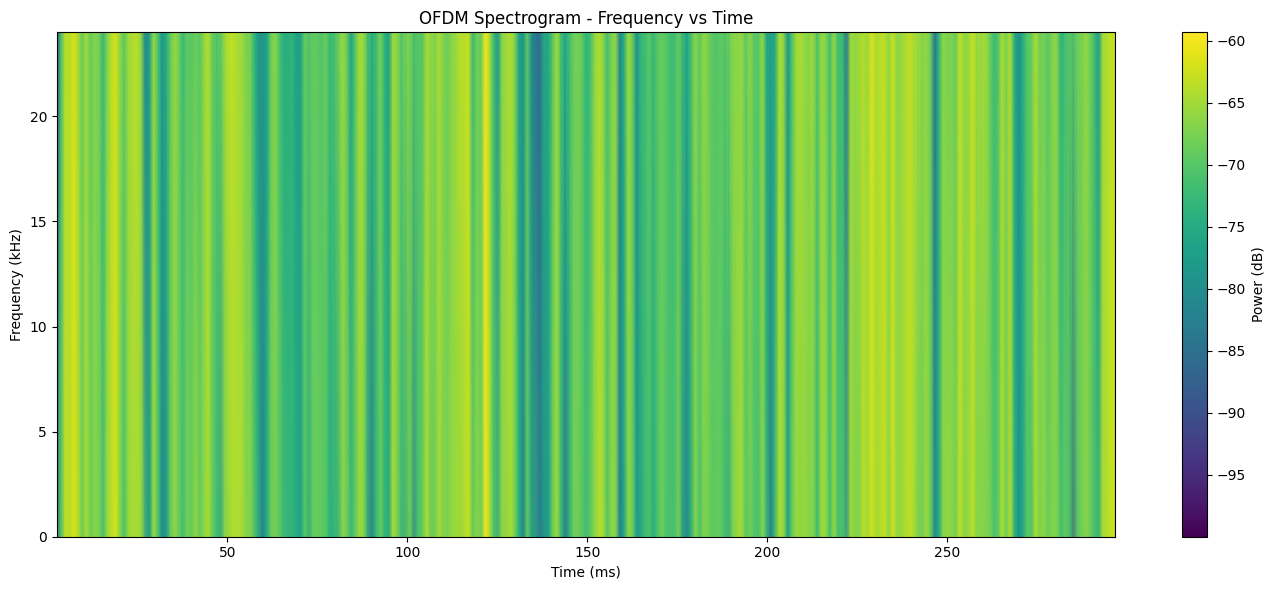

In [224]:
# Spectrogram of OFDM signal
f_spec, t_spec, Sxx = signal.spectrogram(ofdm_signal, fs=fs, 
                                         nperseg=256, noverlap=200, nfft=1024)

plt.figure(figsize=(14,6))
plt.pcolormesh(t_spec*1e3, f_spec/1e3, 10*np.log10(Sxx + 1e-10), 
               shading='gouraud', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (ms)')
plt.title('OFDM Spectrogram - Frequency vs Time')
plt.ylim([0, fs/2/1e3])
plt.tight_layout()

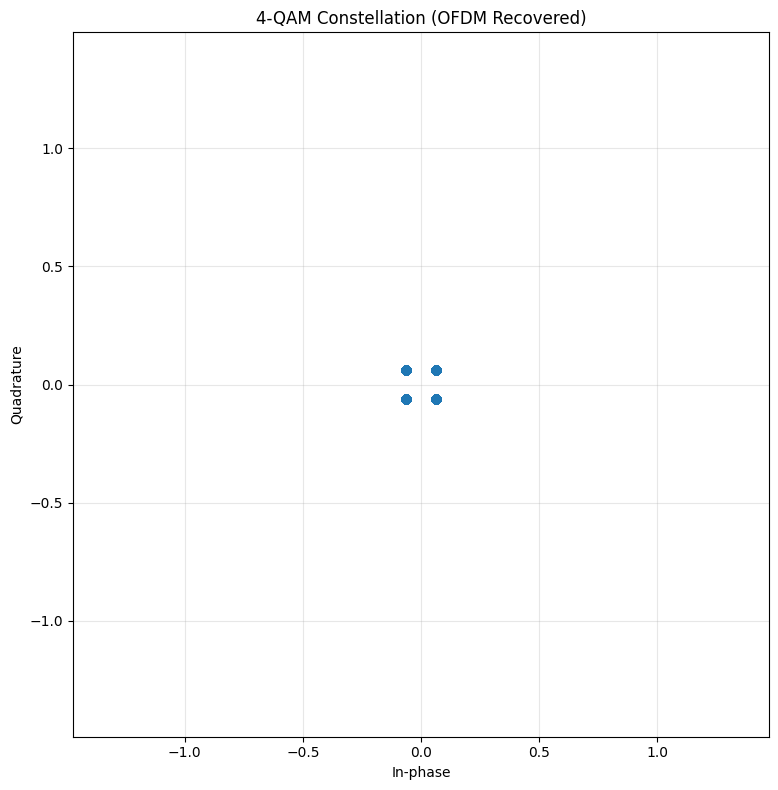

In [227]:
# Demodulate OFDM to see constellation
# Remove cyclic prefix and perform FFT to recover QAM symbols

# Reshape signal into OFDM symbols
ofdm_reshaped = ofdm_signal.reshape(nSym, nfft + cplen)

# Remove cyclic prefix
ofdm_no_cp = ofdm_reshaped[:, cplen:]

# FFT each OFDM symbol to get frequency domain
recovered_symbols = np.fft.fft(ofdm_no_cp, axis=1) / np.sqrt(nfft)

# Flatten all symbols
all_symbols = recovered_symbols.flatten()

# Plot constellation
plt.figure(figsize=(8,8))
plt.scatter(np.real(all_symbols), np.imag(all_symbols))
plt.grid(True, alpha=0.3)
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.title(f'{M_ofdm}-QAM Constellation (OFDM Recovered)')
plt.axis('equal')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.tight_layout()